In [1]:
### import packages here

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


import mwlmc

import mwlmc_util
import mwlmc_plot

import importlib
importlib.reload(mwlmc_util)
importlib.reload(mwlmc_plot)

<module 'mwlmc_plot' from '/Users/sl01701/Documents/Projects/code/mwlmc/tutorial/mwlmc_plot.py'>

### Introduction

The simulations consists of expansion of the Milky Way stellar component 
(`mwd`), the Milky Way halo (`mwhalo`), and the Large Magellanic Cloud halo 
(`lmc`). In this tutorial, we present how we can run orbits in
the full simulation. For a tutorial on how to access the fields, see the 
[fields tutorial](fields_tutorial.ipynb). The advantage of this type of 
simulation is that we can select different moments (such as the dipole or 
quadrupole), and see how this affects all these outputs. For a more detailed 
explanation and example, see e.g.vLilleengen et al. 2022. We also provide the 
option to run orbits in the static, unperturbed Milky Way potential similar to 
the one from [Erkal et al. 2019](https://ui.adsabs.harvard.edu/link_gateway/2019MNRAS.487.2685E/doi:10.1093/mnras/stz1371).



Let's get started. To access the simulation, first, we need to initialize the 
expansions. Afterwards, the functions will be callable via the Model instance:

In [2]:
Model = mwlmc.MWLMC()

Initialising MW ... 


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_coef_file: reading NUMT, LMAX, NORDER from file . . . success!!


### LMC orbit

To get the trajectory of the LMC, we call the `get_lmc_trajectory` function. 
We can adapt the time step if we wanted to:


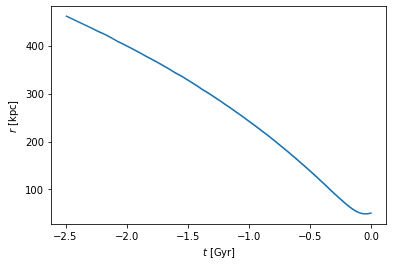

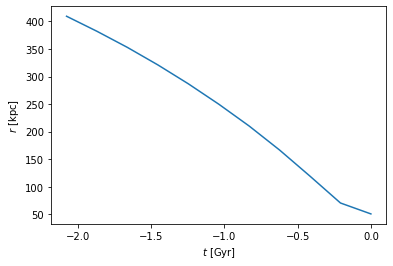

In [21]:
torb, lmcx, lmcy, lmcz = Model.get_lmc_trajectory().T
r = (lmcx**2 + lmcy**2 + lmcz**2)**(0.5)

fig, ax = mwlmc_plot.plot_orbit_time(torb, r)
plt.show()

# As an example, a time step of 0.1 Gyr is too large:
torb_dt, lmcx_dt, lmcy_dt, lmcz_dt = Model.get_lmc_trajectory(dt = 0.1).T
r_dt = (lmcx_dt**2 + lmcy_dt**2 + lmcz_dt**2)**(0.5)

fig, ax = mwlmc_plot.plot_orbit_time(torb_dt, r_dt)
plt.show()

### Selecting different potentials
This simulation allows us to run orbits in different potential setup by 
selecting different harmonic moments, To do so, we can use the `lmcharmonicflag` 
for the LMC (and `mwhharmonicflag` for the `mwhalo` and `mwdharmonicflag` for 
the `mwd`). These flags are unique to the moments we want to choose (by default,
the fully live versions are selected). We can select up to the $l=6$ order in 
any combination we want (with the monopole always being selected). 
The `mwlmc_util.get_harmonic_flag` function returns the flag for our selection. 
If we e.g. want to choose only the even moments $l=(2,4,6)$ we can call 
flag = mwlmc_util.get_harmonic_flag([2,4,6])
print(flag)`flag = mwlmc_util.get_harmonic_flag([2,4,6])`.

In [3]:
flag = mwlmc_util.get_harmonic_flag([2,4,6])
print(flag)

42


The flag for the monopole is $0$, the flag for the dipole is one, the flag for 
the quadrupole is $2$. The flag for combining dipole and quadrupole is $3$. 
For all higher flag best use the function. The flag for the live potential is 
$63$ or any higher number.

### Rewind orbits in the simulation 

We start with the orbits at their current positions and rewind them in the 
potential we choose (default: live). The rewind function takes cartesian 
coordinates $[x, y, z]$, $[v_x, v_y, v_z]$. The rewind time is positive. Any 
time before the simulation will be interpolated. `rewind` returns the positions, velocities, forces, and time at each time step. We now look at a Sun-like orbit:

       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398


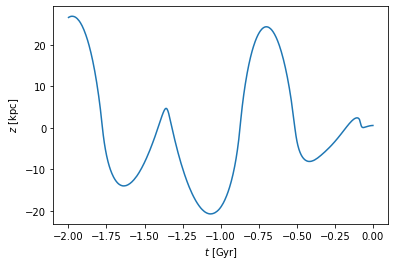

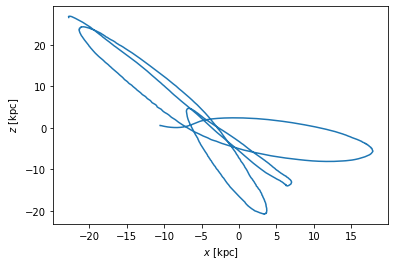

In [4]:
xsun = [-8.27,0.,0.]
vsun = [0.,200.,0.]

orbit = Model.rewind(xsun, vsun,
                     # mwhharmonicflag=64, 
                     rewindtime=2.0, dt=0.001)

ox, oy, oz = orbit[0], orbit[1], orbit[2]
ovx, ovy, ovz = orbit[3], orbit[4], orbit[5]
ofx, ofy, ofz = orbit[6], orbit[7], orbit[8]
ot = orbit[9]

fig, ax = mwlmc_plot.plot_orbit_time(ot, oz, 'z')
fig, ax = mwlmc_plot.plot_orbit(ox, oz, 'x', 'z')


Looking at the evolution of the $z$-position of a Sun-like particle and of its 
orbit, we need to call for **caution when integrating orbits (and analysing 
fields) in the inner Milky Way!!** 

Again, we can rewind $N$ initial conditions. The position and the velocity
inputs need to have the shape $(N, 3)$. Let's have a look at some particles
initialised out of the disc plane:

(10, 3)
       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398


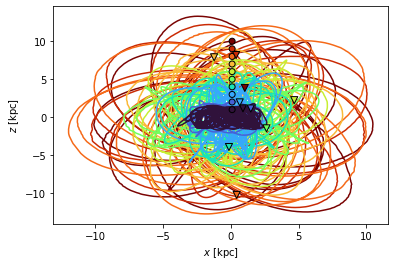

In [23]:
norbits = 10
pos = np.zeros([norbits,3])
vel = np.zeros([norbits,3])

for n in range(0,norbits):
    pos[n] = [0.1,1,1.+n]
    vel[n] = [100.,110.,10.]

print(np.shape(pos))
X = Model.rewind(pos, vel,
                 mwhharmonicflag=63,
                 rewindtime=2.5, dt=0.001)

# print(np.shape(X))
X = np.array(X)


colors = plt.cm.turbo(np.linspace(0, 1, norbits))

fig, ax = plt.subplots()

# plot all orbits 
for i in range(norbits)[::-1]:
    ax.plot(X[:,0][i], X[:,2][i], 
            c=colors[i], zorder=20-i)
    
# plot start position
ax.scatter(X[:,0][:,0], X[:,2][:,0], 
           c=colors, marker='o', 
           edgecolors='k', zorder=50)

# plot end position
ax.scatter(X[:,0][:,-1], X[:,2][:,-1], 
           c=colors, marker='v', s=50, 
           edgecolors='k', zorder=50)

ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')
plt.show()


Let's compare a halo orbit in the monopole `(mwhharmonicflag=0)`, dipole `(mwhharmonicflag=1)`, and live potential `(mwhharmonicflag=63)`:

       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398
       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398
       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398


Text(0, 0.5, '$z$ [kpc]')

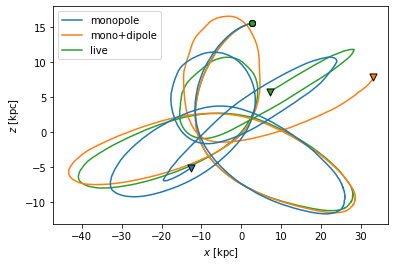

In [24]:
xsun = [5,10.,15.]
vsun = [100.,100.,10.]

flags = [0, 1, 63]
fig, ax = plt.subplots()
labels = ['monopole', 'mono+dipole', 'live']

for i, flag in enumerate(flags):
    orbit = Model.rewind(xsun, vsun,
                         mwhharmonicflag=flag, 
                         rewindtime=2.2, dt=0.001)

    ox, oy, oz = orbit[0], orbit[1], orbit[2]
    ovx, ovy, ovz = orbit[3], orbit[4], orbit[5]
    ofx, ofy, ofz = orbit[6], orbit[7], orbit[8]
    ot = orbit[9]

    
    ax.plot(ox, oz, 
            c='C'+str(i), zorder=20-i, label=labels[i])
    
    # plot start position
    ax.scatter(ox[0], oz[0], 
               c='C'+str(i), marker='o', 
               edgecolors='k', zorder=50)

    # plot end position
    ax.scatter(ox[-1], oz[-1], 
               c='C'+str(i), marker='v', s=50, 
               edgecolors='k', zorder=50)

ax.legend()
ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

### Orbits in a static potential 

We also provide the possibility to evolve orbits in the static Milky Way that 
is the best approximation to the Milky Way of [Erkal et al. 2019](https://ui.adsabs.harvard.edu/link_gateway/2019MNRAS.487.2685E/doi:10.1093/mnras/stz1371) that is not perturbed by the LMC. This is done with the `mworbit` function, in
the same way as the `rewind` function:

fullintegrate.h: tvirbegin is less than 0! --> -0.725775


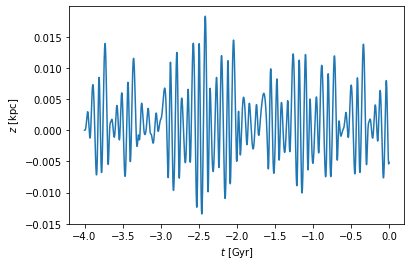

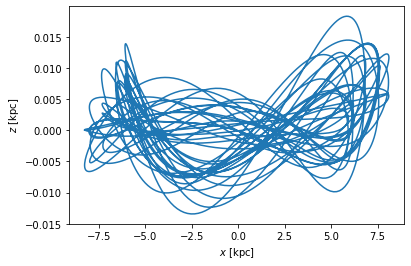

In [7]:
xsun = [-8.27,0.,0.]
vsun = [0.,200.,0.]

orbit = Model.mworbit(xsun, vsun,
                      tbegin=-4, tend=0, dt=0.001)

ox, oy, oz = orbit[0], orbit[1], orbit[2]
ovx, ovy, ovz = orbit[3], orbit[4], orbit[5]
ofx, ofy, ofz = orbit[6], orbit[7], orbit[8]
ot = orbit[9]

fig, ax = mwlmc_plot.plot_orbit_time(ot, oz, 'z')
fig, ax = mwlmc_plot.plot_orbit(ox, oz, 'x', 'z')


In [8]:
ot

array([-4.000e+00, -3.999e+00, -3.998e+00, ..., -3.000e-03, -2.000e-03,
       -1.000e-03])

Here, the orbit is stable and does not deviate from the plane. Again. let's look
at an array of orbits:

(10, 3)
fullintegrate.h: tvirbegin is less than 0! --> -0.725775


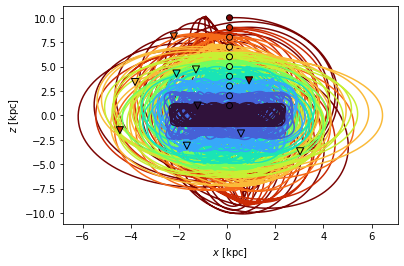

In [9]:
norbits = 10
pos = np.zeros([norbits,3])
vel = np.zeros([norbits,3])

for n in range(0,norbits):
    pos[n] = [0.1,1,1.+n]
    vel[n] = [100.,110.,10.]

print(np.shape(pos))
X = Model.mworbit(pos, vel,
                  tbegin=-4, dt=0.001)

# print(np.shape(X))
X = np.array(X)

colors = plt.cm.turbo(np.linspace(0, 1, norbits))

fig, ax = plt.subplots()

# plot all orbits 
for i in range(norbits)[::-1]:
    ax.plot(X[:,0][i], X[:,2][i], 
            c=colors[i], zorder=20-i)
    
# plot start position
ax.scatter(X[:,0][:,0], X[:,2][:,0], 
           c=colors, marker='o', 
           edgecolors='k', zorder=50)

# plot end position
ax.scatter(X[:,0][:,-1], X[:,2][:,-1], 
           c=colors, marker='v', s=50, 
           edgecolors='k', zorder=50)

ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')
plt.show()

In [10]:
X[:,-1][:,0]

array([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4.])

### Example: Reticulum 3 - LMC satellite

In [11]:
# values from McConnachie & Venn https://ui.adsabs.harvard.edu/abs/2020AJ....160..124M/abstract and https://ui.adsabs.harvard.edu/abs/2020RNAAS...4..229M/abstract
ra = 56.36 
dec = -60.45
dm = 19.81
pmra = 0.36
pmdec =0.05
vhel = 274.2

edm = 0.31
epmra = 0.14
epmdec = 0.25
evhel = 7.5

# https://ui.adsabs.harvard.edu/abs/2015ApJ...813..109D/abstract
dhel = 92
edhel = 0.05*92
# edhel = edm * dhel * 0.461

obs = [ra, dec, dhel, pmra, pmdec, vhel, edhel, epmra, epmdec, evhel]

In [12]:
edhel

4.6000000000000005

       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398
       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398
       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398
       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398


Text(0, 0.5, '$z$ [kpc]')

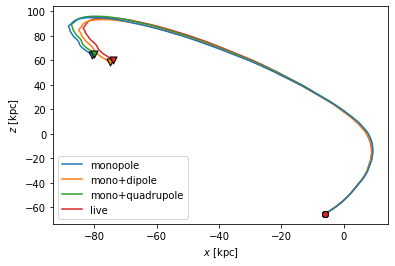

In [13]:
x, y, z, vx, vy, vz = mwlmc_util.radecpms_to_xyzv(ra, dec, dhel, 
                                                  pmra, pmdec, vhel)

pos = [x, y, z]
vel = [vx, vy, vz]

flags = [0, 1, 2, 63]



fig, ax = plt.subplots()
labels = ['monopole', 'mono+dipole', 'mono+quadrupole', 'live']

for i, flag in enumerate(flags):
    orbit = Model.rewind(pos, vel,
                         mwhharmonicflag=flag, 
                         rewindtime=1.7, dt=0.001)

    ox, oy, oz = orbit[0], orbit[1], orbit[2]
    ovx, ovy, ovz = orbit[3], orbit[4], orbit[5]
    ofx, ofy, ofz = orbit[6], orbit[7], orbit[8]
    ot = orbit[9]

    
    ax.plot(ox, oz, 
            c='C'+str(i), zorder=20-i, label=labels[i])
    
    # plot start position
    ax.scatter(ox[0], oz[0], 
               c='C'+str(i), marker='o', 
               edgecolors='k', zorder=50)

    # plot end position
    ax.scatter(ox[-1], oz[-1], 
               c='C'+str(i), marker='v', s=50, 
               edgecolors='k', zorder=51)

ax.legend()
ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

In [14]:
np.sum(np.isnan(oz))

0

#### For realisations within the error 

In [15]:
def make_random_obs(*obs, N=10, seed=265):
    rng = np.random.default_rng(seed)
    ra, dec, dhel, pmra, pmdec, vhel, edhel, epmra, epmdec, evhel = obs
    ra = np.full(N, ra)
    dec = np.full(N, dec)
    dhel = rng.normal(dhel, scale=edhel, size=N)
    pmra = rng.normal(pmra, scale=epmra, size=N)
    pmdec = rng.normal(pmdec, scale=epmdec, size=N)
    vhel = rng.normal(vhel, scale=evhel, size=N)
    return ra, dec, dhel, pmra, pmdec, vhel

In [16]:
ra_N, dec_N, dhel_N, pmra_N, pmdec_N, vhel_N = make_random_obs(*obs, N=10)

In [17]:
cc = mwlmc_util.radecpms_to_xyzv(ra_N, dec_N, dhel_N, pmra_N, pmdec_N, vhel_N)

In [18]:
pos = np.array(cc[:3]).T
vel = np.array(cc[3:]).T

       1.19925       2.25949       22.0138     -0.538617
       (u,v,w)       4.49745       11.0299     -0.892398


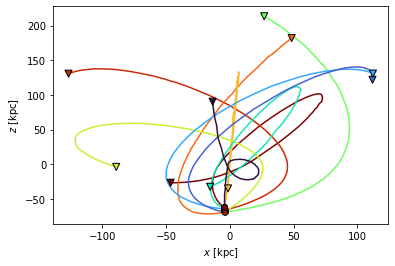

In [19]:
norbits = len(pos)


# print(np.shape(pos))
X = Model.rewind(pos, vel,
                 mwhharmonicflag=63,
                 rewindtime=2.5, dt=0.001)

# print(np.shape(X))
X = np.array(X)


colors = plt.cm.turbo(np.linspace(0, 1, norbits))

fig, ax = plt.subplots()

# plot all orbits 
for i in range(norbits)[::-1]:
    ax.plot(X[:,0][i], X[:,2][i], 
            c=colors[i], zorder=20-i)
    
# plot start position
ax.scatter(X[:,0][:,0], X[:,2][:,0], 
           c=colors, marker='o', 
           edgecolors='k', zorder=50)

# plot end position
ax.scatter(X[:,0][:,-1], X[:,2][:,-1], 
           c=colors, marker='v', s=50, 
           edgecolors='k', zorder=50)

ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')
plt.show()


In [20]:
|

SyntaxError: invalid syntax (525519296.py, line 1)